In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
def get_significant(file_path):
    significants = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            x, y = int(int(data[1])/1000), int(int(data[3])/1000)
            p_value, q_value = float(data[5]), float(data[6])
            concat = int(data[4])
            significants.append((x, y, p_value, q_value, concat))
    return significants

def cal_significant(significants, proportion):
    test = np.array(significants)
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
#         while True:
#             if _values[values_min_numbers_index] < _values[values_sort_index[p]]:
#                 break
#             p += 1
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _p_values = test[:, 2]
    _test = _filter(_p_values, int(_p_values.shape[0]*proportion), test)
    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(subsets = [hr_sig_set, enhanced_sig_set], set_labels = ('1kb', 'enhanced'), set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

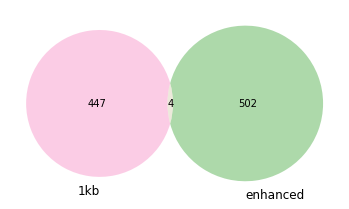

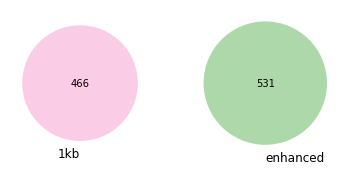

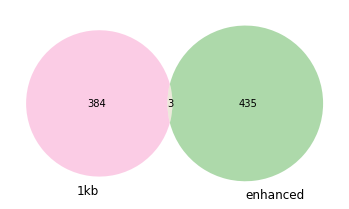

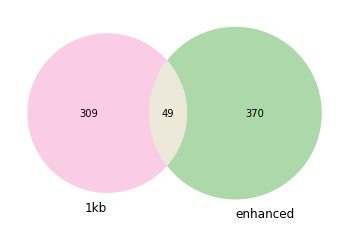

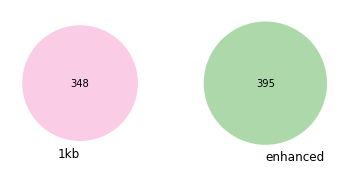

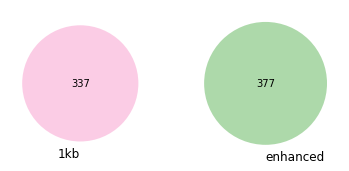

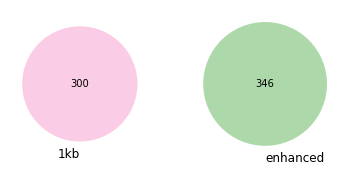

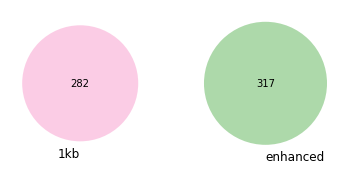

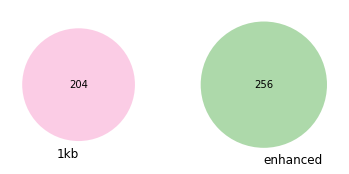

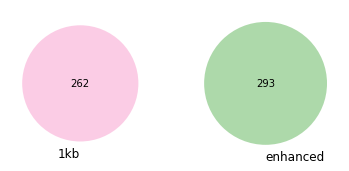

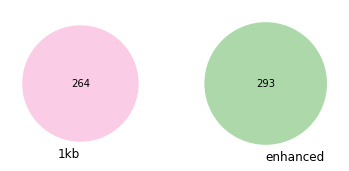

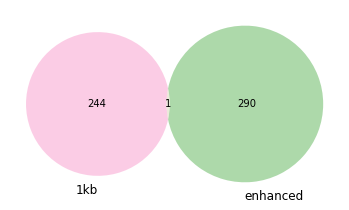

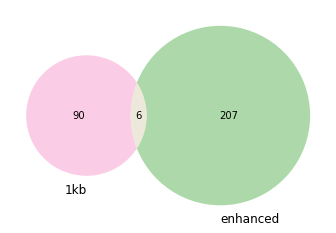

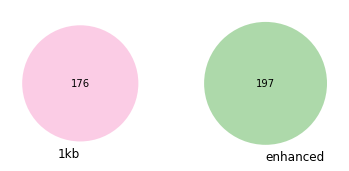

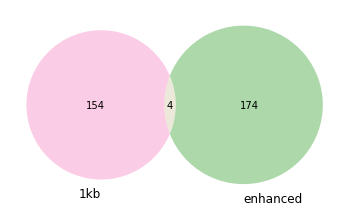

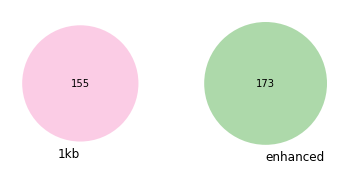

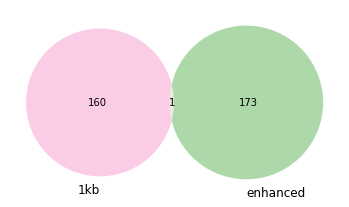

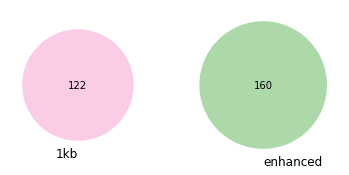

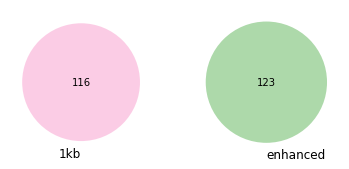

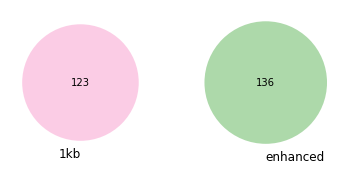

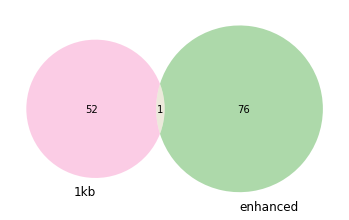

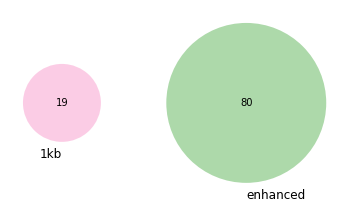

In [3]:
analyse_path = '/data1/lmh_data/MMSR_complete/analyse/GM12878/analyse'
enhanced_path = os.path.join(analyse_path, 'experiment_diff_loop', 'loop', 'enhanced')
hr_path = os.path.join(analyse_path, 'experiment_diff_loop', 'loop', 'hr')
proportion = 0.015

# 未去交集的全部sig
enhanced_sigs = set()
hr_sigs = set()
# 去交集的全部sig
all_enhanced_sig = dict()
all_hr_sig = dict()
for chr in range(1, 23):
    enhanced_file_path = os.path.join(enhanced_path, 'chr{}_1000b'.format(chr), 'outputs', 'FitHiC.spline_pass1.res1000.significances.txt')
    hr_file_path = os.path.join(hr_path, 'chr{}_1000b'.format(chr), 'outputs', 'FitHiC.spline_pass1.res1000.significances.txt')
    enhanced_sig = cal_significant(get_significant(enhanced_file_path), proportion)
    hr_sig = cal_significant(get_significant(hr_file_path), proportion)
    
    _enhanced_sig = set(list(map(tuple, np.array(enhanced_sig)[:, :2])))
    _hr_sig = set(list(map(tuple, np.array(hr_sig)[:, :2])))
    show_venn(_enhanced_sig, _hr_sig)
    # 去交集
    new_enhanced_sig = _enhanced_sig - _hr_sig
    new_hr_sig = _hr_sig - _enhanced_sig
    
    all_enhanced_sig[chr] = new_enhanced_sig
    all_hr_sig[chr] = new_hr_sig
    
    for sig in _enhanced_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        enhanced_sigs.add(tuple(_sig))
    for sig in _hr_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        hr_sigs.add(tuple(_sig))

In [6]:
loops_path = 'loops.txt'
with open(loops_path, 'w') as file_object:
    for chr in range(1, 23):
        chrom = 'chr{}'.format(chr)
        _enhanced_sigs = np.array(list(enhanced_sigs))
        _enhanced_sigs = _enhanced_sigs[np.where(_enhanced_sigs[:, 2]==chrom)[0]]
        _enhanced_sigs = _enhanced_sigs[:, :2].astype(np.float)
        _enhanced_sigs = _enhanced_sigs[np.argsort(_enhanced_sigs[:,0])]

        for i in range(_enhanced_sigs.shape[0]):
            x, y = int(_enhanced_sigs[i, 0])*1000, int(_enhanced_sigs[i, 1])*1000
            file_object.write('\t'.join([chrom, str(x), str(y), '{}:{}-{},2'.format(chrom, x, y)])+'\n')